In [90]:
import otter
grader = otter.Notebook()

In [279]:
import numpy as np
import math
import pandas as pd

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


# 1. The Dataset

In this project, we are exploring movie screenplays. We'll be trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

In [94]:
movies = pd.read_csv('movies.csv')
movies[movies["Title"] == "wild wild west"].iloc[:,[0, 1, 2, 3, 4, 14, 49, 1042, 4004]]

,Title,Year,Rating,Genre,# Words,breez,england,it,bravo
241,wild wild west,1999,4.3,comedy,3446,0.0,0.0,0.021263,0.0


The above cell prints a few columns of the row for the comedy movie *Wild Wild West*.  The movie contains 3446 words. The word "it" appears 74 times, as it makes up  $\frac{74}{3446} \approx 0.021364$ of the words in the movie. The word "england" doesn't appear at all.
This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. Here we'll turn the movie's Title column into its index as well. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [282]:
movies = movies.set_index('Title', drop = False)
movies["Title"] = movies.index

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

## 1.1. Word Stemming
The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

In [662]:
vocab_mapping = pd.read_csv('stem.csv')
stemmed = np.take(movies.columns, np.arange(3, len(movies.columns)))

vocab_table = pd.DataFrame({'Stem': stemmed})
vocab_table = pd.merge(vocab_table, vocab_mapping, on = "Stem", how = "left")
vocab_table[1101:1111]

,Stem,Word
1101,year.1,NaN
1102,shovel,shoveling
1103,shovel,shovels
1104,shovel,shovelling
1105,shovel,shoveler
1106,shovel,shoveled
1107,shovel,shovel
1108,sequenc,sequencing
1109,sequenc,sequencer
1110,sequenc,sequences


#### 1.1.1 - Example
Here we assign `stemmed_message` to the stemmed version of the word "vegetables".

In [291]:
vegetables = vocab_table[vocab_table["Word"] == "vegetables"]
array = np.array(vegetables)

stemmed_message = array.item(0)
stemmed_message

'veget'

#### 1.1.2 - Exploration
Exploring the data: here we find the stem in the dataset has the most words that are shortened to it.

In [294]:
size = vocab_table.groupby("Stem").size() # gives the count of rows for each stem

# formatting
size_table = vocab_table.groupby("Stem").size().reset_index() # turns count table size into an indexed dataframe
size_table["Count"] = np.array(size_table.iloc[:, 1]) # renames/duplicates the Count column to make it accessible (bug?)

max_size = max(size_table["Count"]) # finds the row with the max count
max_row = size_table[size_table["Count"] == max_size]

most_stem = np.array(max_row["Stem"]).item(0)
most_stem

'gener'

#### 1.1.3 - More Exploration
Here we find the longest word in the dataset whose stem wasn't shortened, and assign it to `longest_uncut`. We break ties alphabetically from Z to A.

In [110]:
# array with lengths of each stem
stem_lengths = np.empty(0)
stem_column = np.array(vocab_table["Stem"])

for i in np.arange(vocab_table.shape[0]):
    
    new_stem_len = len(stem_column[i])
    stem_lengths = np.append(stem_lengths, new_stem_len)
    
    
# array with lengths of each word
word_lengths = np.empty(0)
word_column = np.array(vocab_table["Word"])

for i in np.arange(vocab_table.shape[0]):
    
    if type(word_column[i]) != str: # for NaN values in some of the columns
        new_word_len = 0
    else:
        new_word_len = len(word_column[i])
        
    word_lengths = np.append(word_lengths, new_word_len)

    
# add these columns, along with difference, to vocab_table
vocab_table["Stem Len"] = stem_lengths
vocab_table["Word Len"] = word_lengths
vocab_table["Difference"] = stem_lengths - word_lengths

no_diff = vocab_table[vocab_table["Difference"] == 0.0]

# find maximum
maximums = no_diff[no_diff["Stem Len"] == max(no_diff["Stem Len"])]
z_to_a = np.array(maximums.sort_values('Word', ascending = False)["Word"]) # sorted Z to A

longest_uncut = z_to_a.item(0)
longest_uncut

'misunderstand'

## 1.2. Exploratory Data Analysis: Linear Regression

Now, we explore our dataset before trying to build a classifier. To start, we'll look at the relationship between words in proportions. 

The first association we'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space". 

As usual, we'll investigate our data visually before performing any numerical analysis.

Run the cell below to plot a scatter diagram of space proportions vs outer proportions and to create the `outer_space` table.

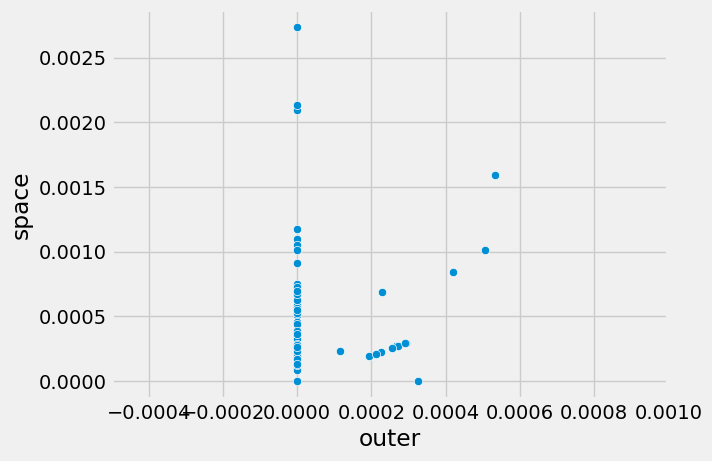

In [298]:
outer_space = movies[["outer", "space"]]
sns.scatterplot(data = outer_space, x = "outer", y = "space")
plt.xlim(-.0005, .001);

#### 1.2.1 - Correlation coefficient
Looking at that chart it is difficult to see if there is an association. We can calculate the correlation coefficient for the association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset to get a sense of the correlation.

In [301]:
outer = movies["outer"]
space = movies["space"]

outer_su = (outer - np.average(outer)) / np.std(outer)
space_su = (space - np.average(space)) / np.std(space)

outer_space_r = np.average(outer_su * space_su)
outer_space_r

0.2829527833012741

#### 1.2.2 - Correlation between new words
To explore, we can choose two *different* words in the dataset with a correlation higher than 0.2 or smaller than -0.2 (that are not *outer* and *space*) and plot a scatter plot with a line of best fit for them. I chose "oh" and "no" because these are words that are commonly found together and will likely have a positive correlation (seen below).

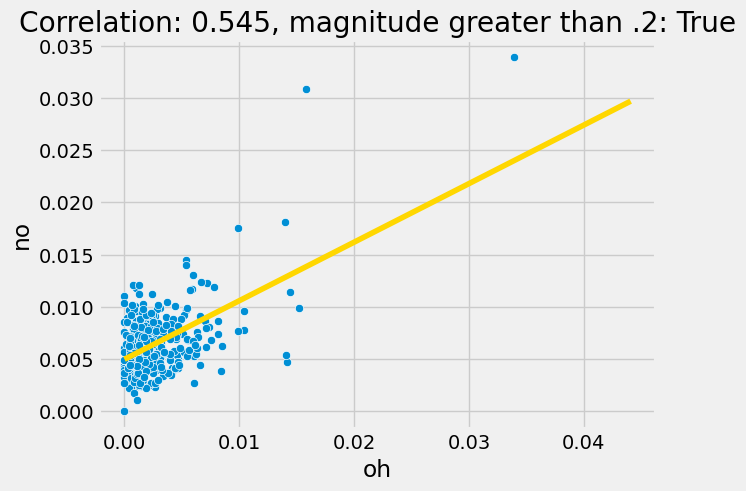

In [304]:
word_x = "oh"
word_y = "no"

# These arrays should make your code cleaner!
arr_x = movies[word_x]
arr_y = movies[word_y]

x_su = (arr_x - np.average(arr_x)) / np.std(arr_x)
y_su = (arr_y - np.average(arr_y)) / np.std(arr_y)

r = np.average(x_su * y_su)

slope = r * (np.std(arr_y) / np.std(arr_x)) # turn back into original units
intercept = np.average(arr_y) - (slope * np.average(arr_x))

# DON'T CHANGE THESE LINES OF CODE
sns.scatterplot(x = arr_x, y = arr_y)
max_x = np.max(movies[word_x])
plt.title(f"Correlation: {np.round(r,3)}, magnitude greater than .2: {abs(r) >= 0.2}")
sns.lineplot(x = [0, max_x * 1.3], y = [intercept, intercept + slope * (max_x*1.3)], color='gold');

## 1.3. Splitting the dataset into Train and Test
We're going to use our `movies` dataset for two purposes.

1. First, we want to *train* movie genre classifiers.
2. Second, we want to *test* the performance of our classifiers.

Hence, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

Below, we separate the datasets into two tables.

In [307]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = len(movies)
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.iloc[np.arange(num_train),:]
test_movies = movies.iloc[np.arange(num_train, num_movies)]

print("Training: ",   len(train_movies), ";",
      "Test: ",       len(test_movies))

Training:  314 ; Test:  56


#### 1.3.1 - Checking that proportions are similar
To compare the proportion of comedy movies in each dataset (train/test), we can visualize it using a simple bar chart (below). Ideally they should be very similar if not the same proportions.

<BarContainer object of 2 artists>

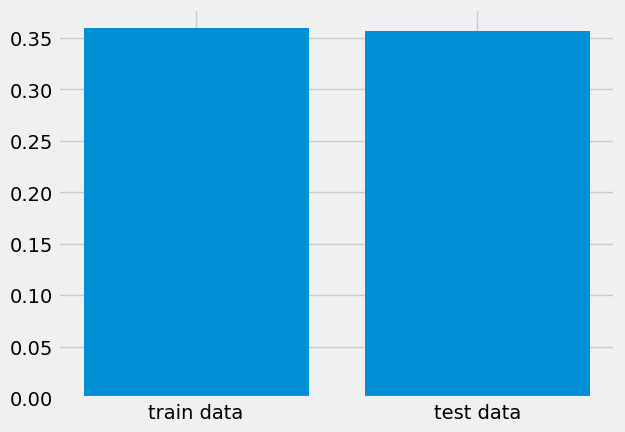

In [310]:
def comedy_proportion(table):
    comedies = table[table["Genre"] == "comedy"]
    num_comedy = len(comedies["Genre"])
    
    return (num_comedy) / (table.shape[0])
    
# Create your barplot
train_proportion = comedy_proportion(train_movies)
test_proportion = comedy_proportion(test_movies)

plt.bar(["train data", "test data"],[train_proportion, test_proportion])

# 2. K-Nearest Neighbors - intro and application

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movies*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

First, we're going to visualize the algorithm.

## 2.1. Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

First, we will choose only 2 features, so we can plot each movie.  The features we will use are the proportions of the words "water" and "feel" in the movie.  Taking the movie *Monty Python and the Holy Grail* (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel".

We will say that the *distance* between two movies is the **Euclidean distance** between them when we plot their features in a scatter diagram.

For example, in the movie *Clerks.* (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel".  Its distance from *Monty Python and the Holy Grail* on this 2-word feature set is $\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379$.  (If we included more or different features, the distance could be different.)

A third movie, *The Avengers* (in the training set), is 0 "water" and 0.00103173 "feel".

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, *Monty Python and the Holy Grail* is more similar to "Clerks." than to the *The Avengers* based on these features, which is makes sense as both movies are comedy movies, while *The Avengers* is a thriller.


In [315]:
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = test_movies.loc[test_movie]
    distances = pd.DataFrame({
            "x_feature": test_row[x_feature],
            "y_feature": test_row[y_feature],
            'Genre': 'unknown',
            'Title': test_movie
                }, index = [0])
    
    for movie in training_movies:
        row = train_movies.loc[movie]
        distances.loc[len(distances)] = [row[x_feature], row[y_feature], row['Genre'], movie]

    sns.set_palette("dark")
    sns.scatterplot(data = distances, x = "x_feature", y = "y_feature", hue = "Genre", s = 70)
    plt.legend(labels = distances["Title"], fontsize = "small", labelcolor = sns.color_palette()[0:3], markerscale=0)

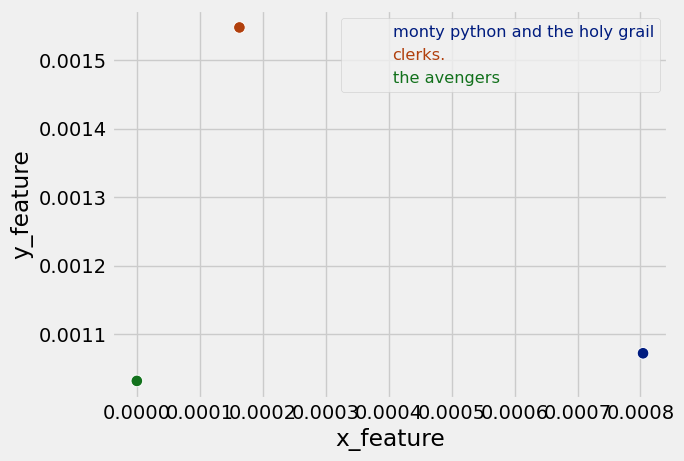

In [127]:
training = ["clerks.", "the avengers"]
plot_with_two_features("monty python and the holy grail", training, "water", "feel")

#### 2.1.1 - distance between 2 movies

Below, we can compute the Euclidean distance between the two movies, *Monty Python and the Holy Grail* and *The Avengers*, using the `water` and `feel` features only.

In [318]:
python = np.array([movies.loc["monty python and the holy grail", "water"],
                   movies.loc["monty python and the holy grail", "feel"]])

avengers = np.array([movies.loc["the avengers", "water"],
                     movies.loc["the avengers", "feel"]])

one_distance = np.sqrt(sum((python - avengers)**2))
one_distance

0.0008050869157478146

Below, we've added a third training movie, *The Silence of the Lambs*. Before, the point closest to *Monty Python and the Holy Grail* was *Clerks.*, a comedy movie. However, now the closest point is *The Silence of the Lambs*, a thriller movie.

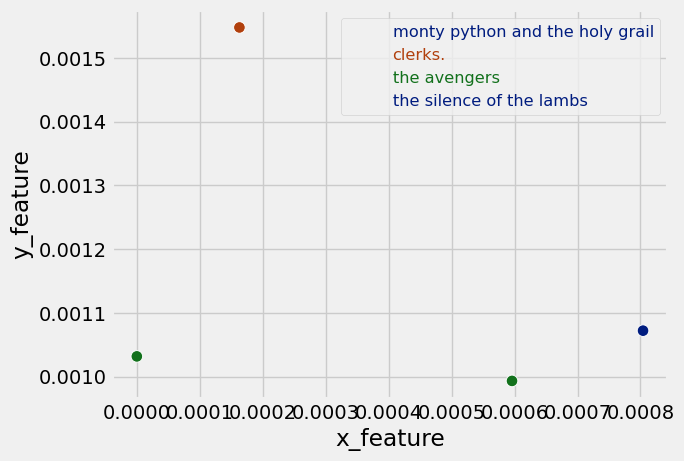

In [320]:
training = ["clerks.", "the avengers", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel");

#### 2.1.2 - distance function
We can create a *function* `distance_two_features` that computes the Euclidean distance between any two movies for us, using two features as input parameters.
(The last two lines call this function to show that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*)

In [323]:
def distance_two_features(title0, title1, x_feature, y_feature):
    
    title0_points = np.array([movies.loc[title0, x_feature],
                              movies.loc[title0, y_feature]])
    
    title1_points = np.array([movies.loc[title1, x_feature],
                              movies.loc[title1, y_feature]])
    
    distance = np.sqrt(sum((title0_points - title1_points)**2))
    
    return distance
    
    
for movie in np.array(["clerks.", "the silence of the lambs"]):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)

clerks. distance:	 0.0007983810687227716
the silence of the lambs distance:	 0.00022256314855564847


#### 2.1.3 - distance from specified movie
We can also create a function `distance_from_python` that computes the Euclidean distance between any given movie and "monty python and the holy grail".

In [329]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    
    dist = distance_two_features("monty python and the holy grail", title, "water", "feel")
    
    
    return dist

distance_from_python("the silence of the lambs")

0.00022256314855564847

#### 2.1.4 - top 5 closest

Exploratory question: Using the features `"water"` and `"feel"`, what are the names and genres of the 5 movies in the **training set** closest to *Monty Python and the Holy Grail*?

To answer this question, we can make a table (below):

In [353]:
# find the distance from python to each movie in the train set
distances = np.empty(0)
for i in np.arange(train_movies.shape[0]):
    new_dist = distance_from_python(train_movies.iloc[i,0])
    distances = np.append(distances, new_dist)
    
train_withdist = train_movies.copy()
train_withdist["distance from python"] = distances

sorted_copy = train_withdist.sort_values("distance from python", ascending = True)
select_columns = sorted_copy.loc[:, ["Title", "Genre", "water", "feel", "distance from python"]]

close_movies = select_columns.iloc[:5, :]
close_movies

,Title,Genre,water,feel,distance from python
Title,,,,,
alien,alien,thriller,0.000709,0.001241,0.000194
tomorrow never dies,tomorrow never dies,thriller,0.000889,0.000889,0.000202
the silence of the lambs,the silence of the lambs,thriller,0.000596,0.000993,0.000223
innerspace,innerspace,comedy,0.000522,0.001044,0.000283
some like it hot,some like it hot,comedy,0.000529,0.000951,0.000301


#### 2.1.5 - classifying based on these 5 nearest neighbors
Next, we'll clasify *Monty Python and the Holy Grail* based on the genres of the closest movies. 

We can use the help of a function `most_common` which returns the most common element of a column of a table (to return the most common genres of the closest movies).

In [359]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    
    unique_labels = np.array(table[label].unique())
    label_count = np.array(table[label].value_counts())
    
    frequency_df = pd.DataFrame({"label": unique_labels, "frequency": label_count})
    
    maximum = frequency_df[frequency_df["frequency"] == max(frequency_df["frequency"])]
    
    most_common = np.array(maximum["label"])[0]
       
    return most_common


# Calling most_common on our table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)

'thriller'

Although we have successfully classified one movie, we can see that the classifier isn't too accurate: It categorized *Monty Python and the Holy Grail* as a thriller movie! 

Next, let's improve our classifier.

# 3. Features

Let's extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

#### 3.0
To do this quickly, we can define a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear).

We can use this function to compute the distance between the first and second movie in the training set *using all of their features*.

In [461]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    
    return np.sqrt(sum(features_array1 - features_array2)**2)


first = np.array(train_movies.iloc[0, 5:])
second = np.array(train_movies.iloc[1, 5:])

distance_first_to_second = distance(first, second)
distance_first_to_second

1.1800131184680485e-14

## 3.1. Creating our own optimized feature set

Unfortunately, using all of the features has some downsides (for example, computing Euclidean distances is computationally expensive/takes a long time when we have lots of features).


So, let's select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or, more broadly, *feature engineering*.

#### 3.1.1 - Common words in each genre:
To conduct effective feature engineering/select more accurate features for distinguishing comedy from thriller movies, let's examine the plot below. This plot shows the average number of times each word occurs in a comedy movie on the horizontal axis and the average number of times it occurs in an thriller movie on the vertical axis, with a line of best fit through them all.

![image](word_plot.png "Title")

Shown in the plot above:
- Words in the bottom left are *uncommon* in both types of movies
- Words in the top right are *common* in both types of movies

- Words in the bottom right are common in comedies but uncommon in thrillers
- Words in the top left are common in thrillers, uncommon in comedies

#### 3.1.2 - making our new array of features
Using the plot above, we can make an array of at least 10 new features: common words that will help us better distinguish between comedy and thriller movies.

Here, I will choose words based on if they had nonsimilar x- and y-values (meaining they would have a high occurence in comedies and low in thrillers, or the other way around), which helps the program to differentiate between the two genres. I'm also going to try to select as many words common in comedies as words common in thrillers.

In [775]:
# my_features is an array of 10 or more features (strings that are column labels)

my_features = np.array(["kill", "well", "question", "dead", "cop", "murder", "gun", "killer", "uh", "oh", "marri", "thank", "love"])


# Select the features of interest from both the train and test sets
train_my_features = train_movies[my_features]
test_my_features = test_movies[my_features]

Let's try to classify the first movie from our test set using these features. (below)

In [777]:
print(f"Movie:", test_movies.iloc[0,:][['Title', 'Genre']])

print("Features:")
test_my_features.iloc[0,:]

Movie: Title    new nightmare
Genre         thriller
Name: new nightmare, dtype: object
Features:


kill        0.000729
well        0.004010
question    0.000000
dead        0.000365
cop         0.000729
murder      0.000000
gun         0.000000
killer      0.000000
uh          0.000000
oh          0.001458
marri       0.000000
thank       0.000365
love        0.001094
Name: new nightmare, dtype: float64

As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.

#### 3.1.3 - finding K nearest neighbors to the movie to classify it
We can use the distance function defined above to compute the distance from the first movie in the test set to all the movies in the training set, **using the updated/engineered set of features**.

This is shown in the sorted table `genre_and_distances`, with one row for each movie in the training set and two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

In [779]:
movie1 = train_movies.iloc[0, 5:]
train_distances = np.empty(0)

for i in np.arange(train_movies.shape[0]):
    new_dist = distance(movie1, train_movies.iloc[i, 5:])
    train_distances = np.append(train_distances, new_dist)
    

genre_copy = train_movies.copy()
genre_copy["Distance"] = train_distances

sorted_distance = genre_copy.sort_values("Distance", ascending = True)
genre_and_distances = sorted_distance[["Genre", "Distance"]]

genre_and_distances

,Genre,Distance
Title,,
10 things i hate about you,comedy,0.000000e+00
bamboozled,comedy,1.078239e-16
say anything...,comedy,1.218643e-16
bachelor party,comedy,1.396452e-16
the boondock saints,thriller,1.586459e-16
...,...,...
shakespeare in love,comedy,5.255226e-14
halloween 4: the return of michael myers,thriller,5.585606e-14
star trek: insurrection,thriller,5.675777e-14


Now we can compute the k-nearest neighbors genre classification (with k=7) of the first movie in the test set. Then check whether your classifier chose the right genre.

In [781]:
top_7 = genre_and_distances.iloc[:7, :]

unique = pd.DataFrame({"unique genre": top_7["Genre"].unique(),
                       "frequency": top_7["Genre"].value_counts()})

most_frequent = unique[unique["frequency"] == max(unique["frequency"])] # find maximum


# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = np.array(most_frequent["unique genre"])[0]


# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set.
real_genre = test_movies.iloc[0,3]
my_assigned_genre_was_correct = my_assigned_genre == real_genre

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, comedy, was not correct.


## 3.2. A classifier function

Let's write a single function that encapsulates the whole process of classification.

#### 3.2.1 - creating the function
This function, `classify`, takes the following four arguments:
* A test row of features for a movie to classify.
* A training table with a column for each feature.
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order.
* `k`, the number of neighbors to use in classification.

It returns the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'comedy'` or the string `'thriller'`).

In [783]:
def classify(test_row, train_rows, train_labels, k):
    """
    Return the most common class among k nearest neigbors to test_row.
    train_rows: training table with a column for each feature
    train_labels: an array of classes (e.g. "comedy","thriller") with the same order & length as train_rows
    k: number of neighbors
    """
    test_row_array = np.array(test_row) # row -> array of values


    # find the euclidean distance between the test row and each row in the training table:
    distances = np.empty(0)
    for row in np.arange(train_rows.shape[0]):
        each_row_array = np.array(train_rows.iloc[row, :]) # goes through each row of the table
        new_dist = distance(test_row_array, each_row_array)
        distances = np.append(distances, new_dist) # array of all the distances to test_row

    
    # add a column for genre and a column for distance to the training table:
    train_copy = train_rows.copy()
    train_copy["genre"] = train_labels
    train_copy["distance"] = distances


    # sort by distance and select closest k neighbors:
    sorted_dist = train_copy.sort_values("distance", ascending = True)
    closest_k = sorted_dist.iloc[:k, :]

    # find most common genre
    genre = most_common("genre", closest_k)
    
    return genre


# test on the first movie in the test set, "New Nightmare"
movie_row = 0
classification = classify(test_my_features.iloc[movie_row,:], train_my_features, np.array(train_movies["Genre"]), 7)

print(f'We classify the movie {test_my_features.index[movie_row]} as {classification}')

We classify the movie new nightmare as thriller


#### 3.2.2 - example prediction

Let's predict the genre of "Tron" in the test set (assigned to `tron_genre` ), using **13 neighbors** and the updated list of features.

In [785]:
tron_row = test_my_features.loc["tron"]

tron_genre = classify(tron_row, train_my_features, np.array(train_movies["Genre"]), 13)
tron_genre

'thriller'

#### 3.2.3 - a simpler classify function
To make it simpler, we can create a classification function that takes as its single argument a row containing the features of interest, and classifies that row using the `classify` function defined above with 13 nearest neighbors.

In [787]:
def classify_feature_row(row):
    
    classification = classify(row, train_my_features, np.array(train_movies["Genre"]), 13)

    return classification

# To test: (this produces 'Thriller' or 'Comedy')
classify_feature_row(test_my_features.iloc[0,:])

'thriller'

## 3.3. Evaluating the performance of our classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

Here, we classify every movie in the test set as `test_guesses`. Then, we can compute the proportion of correct classifications. 

In [789]:
test_guesses = np.empty(0)

for row in np.arange(test_my_features.shape[0]):
    new_classification = classify_feature_row(test_my_features.iloc[row, :])
    test_guesses = np.append(test_guesses, new_classification)

real_genres = np.array(test_movies["Genre"])

matching = test_guesses == real_genres

correct = 0
for i in np.arange(len(matching)):
    if matching[i] == True:
        correct += 1

proportion_correct = correct / len(matching)
proportion_correct

0.7321428571428571

#### 3.3.2. mistakes
An important part of evaluating classifiers is figuring out where they make mistakes. To visualize this, we can make a table called `test_movie_correctness` with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. The last column contains `True` or `False` depending on whether or not the movie was classified correctly.

In [791]:
test_movie_correctness = pd.DataFrame({"Title": np.array(test_movies["Title"]), 
              "Genre": np.array(test_movies["Genre"]), 
              "Was correct": matching})

test_movie_correctness

,Title,Genre,Was correct
0,new nightmare,thriller,True
1,the grifters,thriller,True
2,the body snatcher,thriller,True
3,smoke,comedy,True
4,godzilla,thriller,True
5,mystery of the wax museum,thriller,True
6,rear window,thriller,False
7,u turn,thriller,True
8,jason goes to hell: the final friday,thriller,False
9,the crow: salvation,thriller,False


Looking at the table above, it seems that the thriller movies that were misclassified were, in general, not *crime* movies. This makes sense because the features/words that were used to classify a thriller movie, things like "cop", "murder", "polic", etc. are usually all only associated with a crime plot.

## 4. Explorations and Optimization
Let's build an even better classifier.

#### 4.1 - Improvements
To develop a classifier with better test-set accuracy than `classify_feature_row` (but with the same arguments & applications), I am choosing to increase the value of k (the number of nearest neighbor movies), as well as expanding the list of features/words to be longer. These two changes will hopefully make classification of movie genres more accurate.

In [794]:
# array of features, longer than the first one
new_features = np.array([
    "laugh", "marri", "dead", "heart", "kill", "knew", "murder", "case", "found", "ship", "saw", "captain",  
    "gun", "killer", "uh", "oh", "question", "well", "thank", "hei", "love", "realli", "yeah", "huh", "great"])


train_new = train_movies[new_features]
test_new = test_movies[new_features]


def another_classifier(row):
    
    classification = classify(row, train_new, np.array(train_movies["Genre"]), 13)

    return classification


# for loop to make an array of classifications/guesses
new_test_guesses = np.empty(0)

for i in np.arange(test_new.shape[0]):
    newest_classification = another_classifier(test_new.iloc[i, :])
    new_test_guesses = np.append(new_test_guesses, newest_classification)
    
true_genres = np.array(test_movies["Genre"])
new_correct = new_test_guesses == true_genres # array of True, False: if the guess was correct or not


# proportion correct
num_correct = 0
for n in np.arange(len(new_correct)):
    if new_correct[n] == True:
        num_correct += 1
        
new_proportion_correct = num_correct / len(new_correct)
new_proportion_correct

0.75

### Conclusions:
I was able to improve the accuracy from the first classifier to the second one, by including more features in my list (more words that can be used to classify a movie as either a comedy or a thriller), as well as including a higher k value for the number of nearest neighbors considered in the classification process.

The accuracy improved from around 0.73 to 0.75 as a result.